In [417]:
import fla_optimized as a
from datasets import load_diabetes
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import pickle as pkl
from importlib import reload
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import math
import time
import os
import pickle as pkl
# from torch.utils.tensorboard import SummaryWriter
import utils as u
import matplotlib.pyplot as plt

In [393]:
cwd=os.getcwd()
with open(f"{cwd}/data/diabetes/X.pkl", "rb") as file:
    X_raw = pkl.load(file)
with open(f"{cwd}/data/diabetes/y.pkl", "rb") as file:
    y = pkl.load(file)

In [394]:
y_counts = np.unique(y, return_counts=True)[1]
weight = torch.tensor([y_counts[0]/y_counts[1]], dtype=torch.float32)

In [395]:
imputer = KNNImputer(n_neighbors=5)
X_imputed_not_norm = imputer.fit_transform(X_raw)
scaler = MinMaxScaler()
X = scaler.fit_transform(X_imputed_not_norm)

In [396]:
X.shape

(15149, 108)

In [408]:
reload(a)
head_counts = [0,1,2,3,4,5]#[1,2,3,4,5,6,7,8,9,10,15,20]
test_prediction_dict = {h: [] for h in head_counts}
test_label_list = []
losses = {h: [] for h in head_counts}

forward_times = []
loss_times = []
backwards_times = []
optimizer_times = []

for seed in range(10):
    for i, head in enumerate(head_counts):
        print(f'seed {seed+1}, with {head} heads')
        #split data
        X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.2, random_state=seed)
        X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, stratify=y_train, test_size=0.1, random_state=seed)
        train_dataset = a.npDataset(X_train,y_train)
        test_dataset = a.npDataset(X_test,y_test)
        val_dataset = a.npDataset(X_val,y_val)
        batch_size = 64
        train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        #make model
        hidden_dims = [50,25,10]
        attn_heads = head
        model = a.FLANN(input_dim=108, hidden_dims=hidden_dims, output_dim=1, attn_heads=attn_heads, activation=nn.ReLU, agg='sum')
        # model = a.FLALR(input_dim=108, num_heads=head)
        criterion = nn.BCEWithLogitsLoss(pos_weight=weight)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        #train
        num_epochs = 500 #for diagnosing problems
        best_val_loss = float('inf')
        best_model = None
        patience = 10
        early_stop_counter = 0
        # print(f'initial sem weights: {model.flas[0].sem_weights.data}')
        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                start_f = time.time()
                outputs = model(inputs)
                end_f = time.time()
                # print(f'forwards: {end_f-start_f:.4f}')
                forward_times.append(end_f-start_f)
                labels = labels.unsqueeze(1)
                start_l = time.time()
                loss = criterion(outputs, labels)
                end_l = time.time()
                loss_times.append(end_l-start_l)
                start_b = time.time()
                loss.backward()
                end_b = time.time()
                # print(f'back: {end_b-start_b:.4f}')
                backwards_times.append(end_b-start_b)
                start_o = time.time()
                optimizer.step()
                end_o = time.time()
                optimizer_times.append(end_o-start_o)

            model.eval()
            val_losses = []
            for inputs, labels in val_loader:
                with torch.no_grad():
                    outputs = model(inputs)
                    labels = labels.unsqueeze(1)
                    val_loss = criterion(outputs, labels)
                    val_losses.append(val_loss.item())
            
            avg_val_loss = np.mean(val_losses)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = model.state_dict()
                early_stop_counter = 0
            else:
                early_stop_counter += 1
            
            if early_stop_counter >= patience:
                print(f'Early stopping after epoch {epoch+1} with validation loss {best_val_loss:.4f}')
                break
        model.load_state_dict(best_model)
        # print(f'final sem weights: {model.flas[0].sem_weights.data}')
        #eval
        test_losses = []
        test_predictions = []
        test_true_labels = []

        for inputs, labels in test_loader:
            with torch.no_grad():
                outputs = model(inputs)
                labels = labels.unsqueeze(1)
                test_loss = criterion(outputs, labels)
                test_losses.append(test_loss.item())
                test_predictions.extend(outputs.cpu().numpy())
                test_true_labels.extend(labels.cpu().numpy())
        avg_test_loss = np.mean(test_losses)
        test_predictions_f1 = [y>0.5 for y in test_predictions]
        test_score = f1_score(test_true_labels, test_predictions_f1)
        print(f'Test Loss: {avg_test_loss:.4f}, Test Score: {test_score:.4f} for seed {seed+1} and {head} heads.')
        if i == 0:
            test_label_list.append(test_true_labels)
        test_prediction_dict[head].append(test_predictions)
        losses[head].append(avg_test_loss)
# with open ("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/diabetes/test_pred_dict_1_to_4.pkl", "wb") as file:
#     pkl.dump(test_prediction_dict, file=file)
# with open ("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/diabetes/test_losses_dict_1_to_4.pkl", "wb") as file:
#     pkl.dump(losses, file=file)
# with open ("/Users/aviadsusman/Documents/Python_Projects/FeatureLevelAttention/FLA/results/diabetes/test_labels.pkl", "wb") as file:
#     pkl.dump(test_label_list, file=file)

seed 1, with 0 heads
Epoch 1, Validation Loss: 1.1587
Epoch 2, Validation Loss: 1.1306
Epoch 3, Validation Loss: 1.1234
Epoch 4, Validation Loss: 1.1274
Epoch 5, Validation Loss: 1.1199
Epoch 6, Validation Loss: 1.1246
Epoch 7, Validation Loss: 1.1222
Epoch 8, Validation Loss: 1.1278
Epoch 9, Validation Loss: 1.1351
Epoch 10, Validation Loss: 1.1171
Epoch 11, Validation Loss: 1.1338
Epoch 12, Validation Loss: 1.1317
Epoch 13, Validation Loss: 1.1452
Epoch 14, Validation Loss: 1.1379
Epoch 15, Validation Loss: 1.1668
Epoch 16, Validation Loss: 1.1936
Epoch 17, Validation Loss: 1.2329
Epoch 18, Validation Loss: 1.2390
Epoch 19, Validation Loss: 1.2245
Epoch 20, Validation Loss: 1.3637
Early stopping after epoch 20 with validation loss 1.1171
Test Loss: 1.4541, Test Score: 0.2482 for seed 1 and 0 heads.
seed 1, with 1 heads
Epoch 1, Validation Loss: 1.1507
Epoch 2, Validation Loss: 1.1298
Epoch 3, Validation Loss: 1.1262
Epoch 4, Validation Loss: 1.1198
Epoch 5, Validation Loss: 1.1439
Ep

In [409]:
print(np.median(forward_times))
print(np.median(loss_times))
print(np.median(backwards_times))
print(np.median(optimizer_times))

0.006582975387573242
8.702278137207031e-05
0.011564016342163086
0.0005929470062255859


In [410]:
model

FLANN(
  (linears): ModuleList(
    (0): Linear(in_features=108, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
    (2): Linear(in_features=25, out_features=10, bias=True)
  )
  (linear_norms): ModuleList(
    (0): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((25,), eps=1e-05, elementwise_affine=True)
    (2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  )
  (flas): ModuleList(
    (0-3): 4 x FLAttention(
      (alphas): ParameterDict(
          (query): Parameter containing: [torch.FloatTensor of size 1x5]
          (key): Parameter containing: [torch.FloatTensor of size 1x5]
          (value): Parameter containing: [torch.FloatTensor of size 5]
      )
      (betas): ParameterDict(
          (query): Parameter containing: [torch.FloatTensor of size 1x5]
          (value): Parameter containing: [torch.FloatTensor of size 1x5]
      )
    )
  )
  (fla_norms): ModuleList(
    (0): LayerNorm((108,), eps=1e-05, 

In [411]:
f'Average batch time: {(np.median(forward_times)+np.median(loss_times)+np.median(backwards_times)+np.median(optimizer_times))*110}'

'Average batch time: 2.0709657669067383'

In [420]:
fmaxes = {}
for k,v in test_prediction_dict.items():
    fmaxes[k] = []
    for i in range(10):
        activated_preds = [F.sigmoid(torch.tensor(x)) for x in v[i]]
        fmaxes[k].append(u.fmax_score(test_label_list[i], activated_preds)[0])
    print(k, np.median(fmaxes[k]))

0 0.2900998331624251
1 0.3041183831129971
2 0.29882600294551886
3 0.30407493606732405
4 0.2958335137140913
5 0.2967751592773812


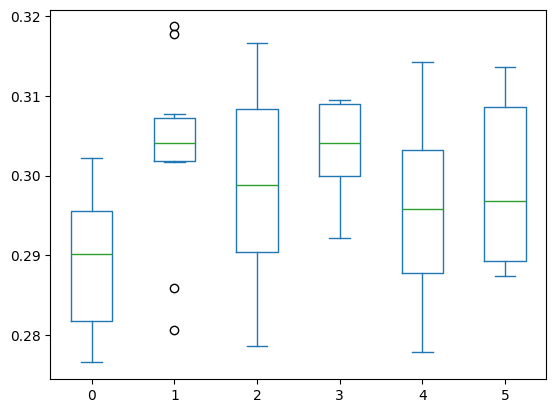

In [413]:
fmaxes_df = pd.DataFrame(fmaxes)
fmaxes_df.plot.box()
plt.show()

In [414]:
f1s = {}
for k,v in test_prediction_dict.items():
    f1s[k] = []
    for i in range(10):
        activated_preds = [u.sig(x)>0.5 for x in v[i]]
        f1s[k].append(f1_score(test_label_list[i], activated_preds))
    print(k, np.median(f1s[k]))

0 0.2811052598942011
1 0.29271249544511163
2 0.2883644013744008
3 0.2905260707635009
4 0.2785725554772903
5 0.2854447534409447


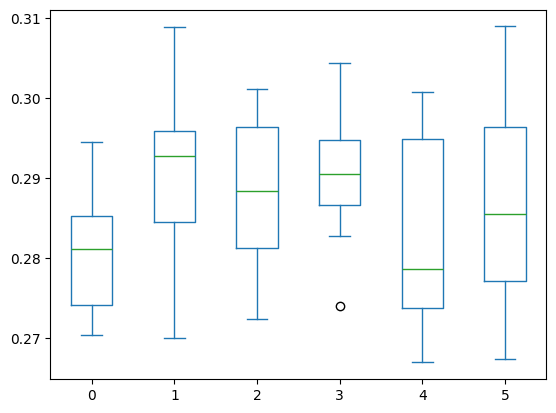

In [415]:
f1s_df = pd.DataFrame(f1s)
f1s_df.plot.box()
plt.show()